# Course project - Machine Learning on Big Data - Boston Housing Dataset
***
NB : To fairly compare all the methods on the Boston Housing "real" dataset, we show the evolution of the loss against **the number of epochs** for all the plots of this notebook. This is different from the other notebook where we use a simple toy dataset and plot the evolution of the loss against the number of gradient updates.
***
In the following, we perform various implementations of gradient descent from [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747.pdf) by Sebastian Ruder (2017)

In this project, our main objective is to solve a **linear regression** problem by minimizing the Mean Square Loss (MSE) between the model predictions $h_{\omega}(x^{(i)})$ and the ground truth $y^{(i)}$ :

$$ \mathcal{J}_{MSE} = \dfrac{1}{n} \sum_{i=1}^{n} ( h_{\omega}(x^{(i)}) - y^{(i)})^{2}$$

where : 
* $\mathcal{D} = \{x^{(i)} ; y^{(i)}\}_{i=1}^{n}$ is the training dataset
* $\omega$ are the weights of the model $\in \mathbb{R}^{1xd}$
* $h_{\omega}$ is a linear approximator : $h_{\omega}(x^{(i)}) = \sum_{i=1}^{d} \omega_i x_{j}^{(i)} = \omega^{T} x_{j}$
#### <font color=blue>  Students : Louis Monier & Vincent Gouteux </font>

In [1]:
import findspark 
findspark.init() 
import pyspark
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import load_boston, load_diabetes
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [2]:
sc = pyspark.SparkContext(appName="Course Project")

## 0 - Data preparation
***
We decided to use the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) which contains information collected by the U.S Census Service concerning housing in the area of Boston Mass.

There are a total of 506 samples and 13 attributes. 

Feature details :
* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per $\$10,000$
* PTRATIO - pupil-teacher ratio by town
* B - $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town
* LSTAT - $\%$ lower status of the population

In [3]:
X, y = load_boston(return_X_y=True)
data = np.hstack((X, y.reshape(-1,1)))

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

n = X.shape[0] # number of examples
d = X.shape[1] # number of features 
print("Number of examples : ", n)
print("Number of features : ", d)

X = data[:,:-1]
y = data[:,-1].reshape(-1,1)
w_star = np.dot(np.linalg.pinv(X), y).T

Number of examples :  506
Number of features :  13


## 1 - Warm up with Vanilla Gradient Descent (aka Batch Gradient Descent)

Vanilla Gradient Descent (Vanilla GD) computes the gradient of the loss w.r.t. to the parameters θ for the entire training dataset:

$$ \omega = \omega - \eta . \nabla{\omega} \mathcal{J}(\omega) $$

We mention once and for all (here in the case of Vanilla GD), the derivation of the gardient : 
$$ \nabla{\omega} \mathcal{J}_{MSE} = \dfrac{2}{n} \sum_{i=1}^{n} ( h_{\omega}(x^{(i)}) - y^{(i)}) . x^{(i)} $$
***

In [4]:
w = np.zeros((1,d)) # initialization weights 
eta = 1e-1 # step-size 
num_epochs = 20 # number of iteration
history_GD = []

print("* Start training..")
ts = time.time()
for i in range(num_epochs):
    
    rdd = sc.parallelize(data) # create RDD
    grad = rdd.map(lambda x : 2 * ( np.dot(w, x[:-1]) - x[-1] ) * x[:-1]) # compute gradient for all data points
    grad = grad.reduce(lambda x,y : (x+y)) / n # sum all gradients
    
    loss = (rdd.map(lambda x : ( np.dot(w, x[:-1]) - x[-1] )**2 ).reduce(lambda x,y : (x+y))) / n  # compute loss
    history_GD.append(loss[0])
    
    w -= eta * grad # perform Vanilla GD
    
    print("Iter : [{}/{}] ; Loss = {:.3f}".format(i, num_epochs, loss[0]))
        
t_gd = time.time() - ts
print("* End training..")

* Start training..
Iter : [0/20] ; Loss = 1.000
Iter : [1/20] ; Loss = 0.504
Iter : [2/20] ; Loss = 0.405
Iter : [3/20] ; Loss = 0.357
Iter : [4/20] ; Loss = 0.329
Iter : [5/20] ; Loss = 0.311
Iter : [6/20] ; Loss = 0.300
Iter : [7/20] ; Loss = 0.293
Iter : [8/20] ; Loss = 0.288
Iter : [9/20] ; Loss = 0.285
Iter : [10/20] ; Loss = 0.282
Iter : [11/20] ; Loss = 0.280
Iter : [12/20] ; Loss = 0.279
Iter : [13/20] ; Loss = 0.277
Iter : [14/20] ; Loss = 0.276
Iter : [15/20] ; Loss = 0.275
Iter : [16/20] ; Loss = 0.274
Iter : [17/20] ; Loss = 0.273
Iter : [18/20] ; Loss = 0.272
Iter : [19/20] ; Loss = 0.272
* End training..


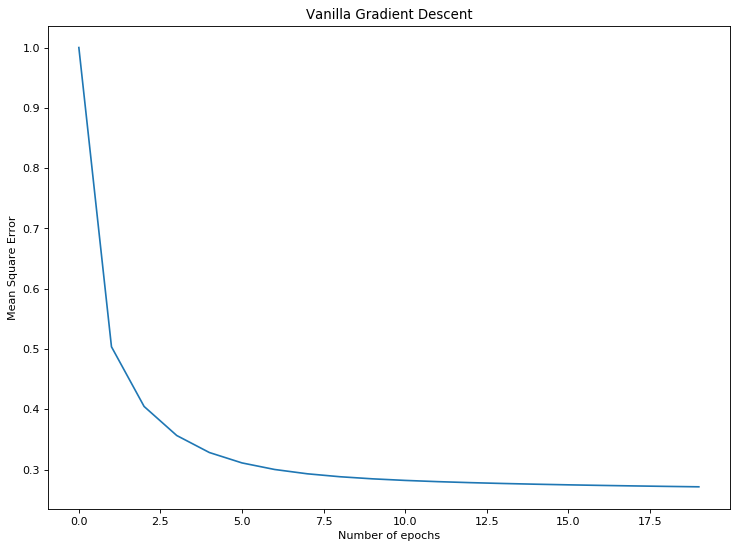

In [5]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history_GD)
plt.xlabel("Number of epochs")
plt.ylabel("Mean Square Error")
plt.title("Vanilla Gradient Descent")
plt.show()

## 2 - Mini-batch Gradient Descent
***
Mini-batch gradient descent performs an update for every mini-batch of n training examples:


$$ \omega = \omega - \eta . \nabla{\omega} \mathcal{J}(\omega ; x^{(i:i+n)} ; y^{(i:i+n)}) $$

In [6]:
# PARTITION WE ARE GOING TO USE FOR ALL GRADIENT DESCENT METHODS
nb_repart = 20 # number of batchs  
assert(n > nb_repart)
batch_size = n // nb_repart
print("Number of partitions :", nb_repart)
print("Batch size :", batch_size)

rdd = sc.parallelize(data)
rdd = rdd.repartition(nb_repart).cache() # divide the data in "nb_repart" number of partitions
rdd = rdd.glom().zipWithIndex() # coalescing all elements within each partition into a list

Number of partitions : 20
Batch size : 25


In [7]:
w = np.zeros((1,d)) # initialization weights 
eta = 1e-2 # step-size 
num_epochs = 20 # number of iteration
#log_iterval = nb_iter // 1
history_BGD = []
    
print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0. 
    
    for j in range(nb_repart):

        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            grad = batch.map(lambda x: 2 * ( np.dot(w, x[:-1]) - x[-1] ) * x[:-1])
            grad = grad.reduce(lambda a,b: (a+b)) / n_in_batch
            
            loss_batch = (batch.map(lambda x : ( np.dot(w, x[:-1]) - x[-1] ) **2 ).reduce(lambda x,y : (x+y)))
            loss += loss_batch[0]

            w -= eta * grad

    loss /= n
    history_BGD.append(loss)            
    i += 1  
    print("Iter : [{}/{}] ; Loss = {:.3f}".format(i, num_epochs, loss)) 
    
t_bgd = time.time() - ts    
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.580
Iter : [2/20] ; Loss = 0.409
Iter : [3/20] ; Loss = 0.352
Iter : [4/20] ; Loss = 0.325
Iter : [5/20] ; Loss = 0.311
Iter : [6/20] ; Loss = 0.303
Iter : [7/20] ; Loss = 0.298
Iter : [8/20] ; Loss = 0.294
Iter : [9/20] ; Loss = 0.292
Iter : [10/20] ; Loss = 0.289
Iter : [11/20] ; Loss = 0.287
Iter : [12/20] ; Loss = 0.286
Iter : [13/20] ; Loss = 0.285
Iter : [14/20] ; Loss = 0.283
Iter : [15/20] ; Loss = 0.282
Iter : [16/20] ; Loss = 0.281
Iter : [17/20] ; Loss = 0.281
Iter : [18/20] ; Loss = 0.280
Iter : [19/20] ; Loss = 0.279
Iter : [20/20] ; Loss = 0.278
* End training..


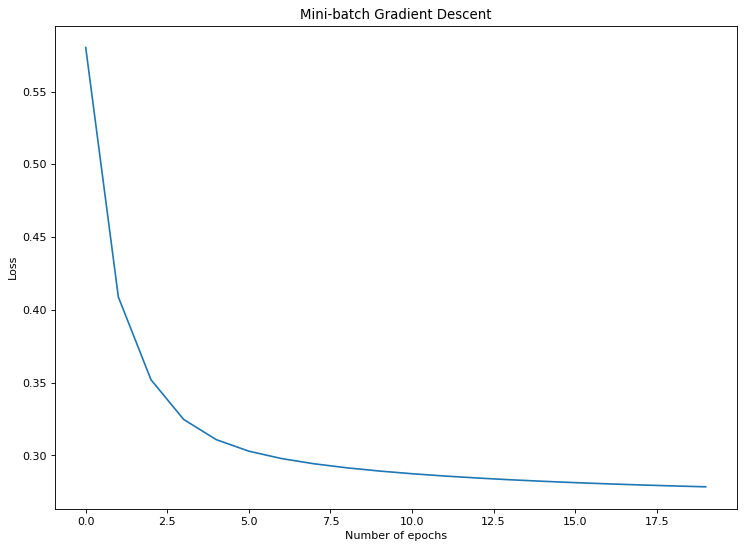

In [8]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history_BGD)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Mini-batch Gradient Descent")
plt.show()

## 3 - Stochastic Gradient Descent (SGD)
***
We tried several methods to perform SGD. The first one was to create as many repartitions as points in the dataset. We observed the repartitions were not uniform which resulted in a lot of of empty useless RDDs. Moreover, even if we dealt with empty RDDs, the running time was very long, which is the opposite of what SGD was designed for. 

We then decided to move on and implement SGD using some tricks. This approach does not exploit as much the benefits of the Map Reduce framework but it works properly. As many optimizers in the following are based on SGD, we decided to keep this version to have a stable, well-performing reference and show relevant comparisons. To be as thorough as possible, we also implement all the following gradient descent variants based on classic gradient descent.

We recall the gradient update rule for SGD which consists to uniformaly-at-random select an example from the dataset $\{x^{(i)} ; y^{(i)}\}$ (instead of the entire dataset for Vanilla GD or a subset of the dataset for Batch GD) and evaluate the gradient : 

$$ \omega = \omega - \eta . \nabla{\omega} \mathcal{J}(\omega ; x^{(i)} ; y^{(i)}) $$

In [9]:
w = np.zeros((1,d)) # initialization weights 
eta = 1e-4 # step-size 
num_epochs = 20 # number of iteration
#log_iterval = nb_iter // 10
history_SGD = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0. 
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            
            for (k,r) in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2 * x * (np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]
                
                w -= eta * grad    
    
    loss /= n
    history_SGD.append(loss) 
    i += 1 
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss)) 
        
t_sgd = time.time() - ts       
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.80107
Iter : [2/20] ; Loss = 0.58305
Iter : [3/20] ; Loss = 0.49065
Iter : [4/20] ; Loss = 0.44009
Iter : [5/20] ; Loss = 0.40630
Iter : [6/20] ; Loss = 0.38121
Iter : [7/20] ; Loss = 0.36171
Iter : [8/20] ; Loss = 0.34627
Iter : [9/20] ; Loss = 0.33395
Iter : [10/20] ; Loss = 0.32406
Iter : [11/20] ; Loss = 0.31608
Iter : [12/20] ; Loss = 0.30960
Iter : [13/20] ; Loss = 0.30432
Iter : [14/20] ; Loss = 0.29998
Iter : [15/20] ; Loss = 0.29639
Iter : [16/20] ; Loss = 0.29340
Iter : [17/20] ; Loss = 0.29088
Iter : [18/20] ; Loss = 0.28875
Iter : [19/20] ; Loss = 0.28693
Iter : [20/20] ; Loss = 0.28535
* End training..


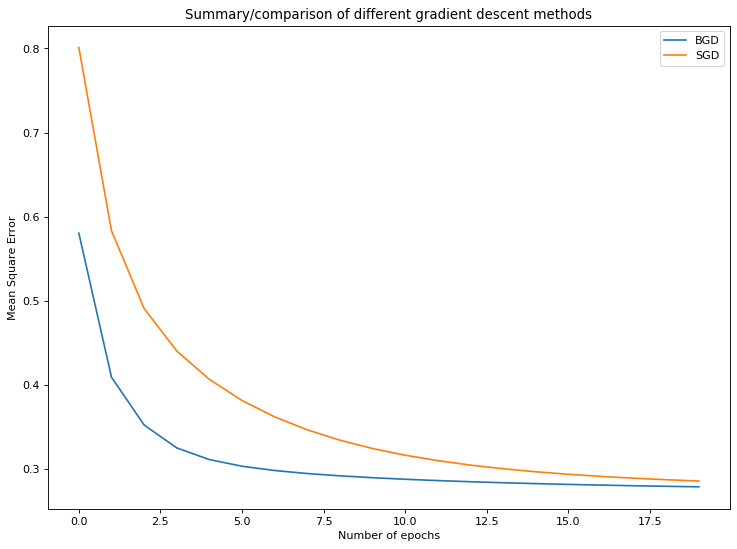

In [10]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history_BGD, label = 'BGD')
plt.plot(history_SGD, label = 'SGD')

plt.xlabel("Number of epochs")
plt.ylabel("Mean Square Error")
plt.title('Summary/comparison of different gradient descent methods')
plt.legend();

Here we sums up pros and cons of basic gradient methods seen above (based on the [article](https://arxiv.org/pdf/1609.04747.pdf)) : 
* Vanilla GD can be very slow and is intractable for datasets that do not fit in memory. Here we used a toy training set so the method works and show good convergence.
* Vanilla GD is redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update
* SGD does away with this redundancy by performing one update at a time. It is much faster than vanilla GD and can be used online. However, SGD has a much high variance.
* Mini-batch GD takes the best of both worlds. It is a trade-off between vanilla GD and SGD. 

Now, let's review some more sophisticated gradient descent optimization algorithms.

## 4 - Momentum
***
SGD is subject to oscillations during training. Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations. The method consists of adding a fraction $\gamma$ of the update vector of the past time step to the current update vector :

$$ v_t = \gamma v_{t-1} + \eta  \nabla{\omega} \mathcal{J}(\omega) $$
$$ \omega = \omega - v_t $$

In [11]:
w = np.zeros((1,d)) # initialization weights 
eta = 1e-4 # step-size 
num_epochs = 20 # number of iteration
gamma = 0.9
#log_iterval = nb_iter // 10
history_momentum = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()

        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2 
                loss += loss_point[0]
                
                if (k == 0):
                    vlast = 0
                    v = eta*grad
                else :
                    v = gamma * vlast + eta * grad
                    vlast = v

                w -= v

    i += 1  
    loss /= n     
    history_momentum.append(loss)
    
    print(np.linalg.norm(w - w_star))
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))

t_momentum = time.time() - ts   
print("* End training..")

* Start training..
0.5643079807444732
Iter : [1/20] ; Loss = 0.51501
0.49555230010218093
Iter : [2/20] ; Loss = 0.33399
0.46138919519831534
Iter : [3/20] ; Loss = 0.30479
0.4370000248842492
Iter : [4/20] ; Loss = 0.29782
0.4163192503797947
Iter : [5/20] ; Loss = 0.29510
0.3977641113467626
Iter : [6/20] ; Loss = 0.29322
0.38085460642790003
Iter : [7/20] ; Loss = 0.29157
0.36538360830599065
Iter : [8/20] ; Loss = 0.29007
0.3512096200758577
Iter : [9/20] ; Loss = 0.28871
0.33820867626995244
Iter : [10/20] ; Loss = 0.28751
0.3262659731003978
Iter : [11/20] ; Loss = 0.28645
0.31527595426400595
Iter : [12/20] ; Loss = 0.28553
0.3051431690164564
Iter : [13/20] ; Loss = 0.28473
0.2957824537654243
Iter : [14/20] ; Loss = 0.28402
0.28711847362949194
Iter : [15/20] ; Loss = 0.28341
0.27908489426437477
Iter : [16/20] ; Loss = 0.28287
0.27162340365753446
Iter : [17/20] ; Loss = 0.28240
0.26468271993846665
Iter : [18/20] ; Loss = 0.28198
0.25821765799326596
Iter : [19/20] ; Loss = 0.28161
0.25218828

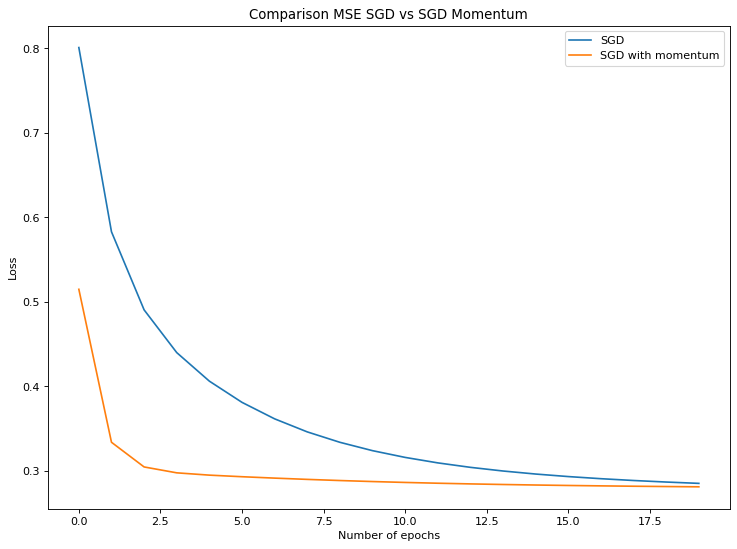

In [12]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history_SGD, label = 'SGD')
plt.plot(history_momentum, label = 'SGD with momentum')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Comparison MSE SGD vs SGD Momentum')
plt.legend();

As the gamma parameter seems to play an important role in the momentum gradient descent, we decided to perform hyperparameter tuning to estimate optimal range of values.

In [13]:
w = np.random.randn(1,d) # initialization weights 
eta = 1e-2 # step-size 
num_epochs = 20 # number of iteration
gamma = 0.9
#log_iterval = nb_iter // 10
history_gamma = {}

gammas = [round(i*0.1,1) for i in range(10)]
print("* Start training..")
for gamma in gammas:
    w = np.random.randn(1,d) 
    history_gamma[str(gamma)] = []
    
    i = 0
    while i < gamma:
        for j in range(nb_repart):
            batch = rdd.filter(lambda x: x[1] == j)
            batch = batch.flatMap(lambda x: x[0])
            n_in_batch = batch.count()

            if (n_in_batch > 0):
                for k,r in enumerate(batch.take(n_in_batch)) : 
                    x = r[:d]
                    y = r[d:]
                    grad = 2*x*(np.dot(w,x) - y)
                    loss = (np.dot(w,x) - y)**2 
                    history_gamma[str(gamma)].append(loss[0])

                    if (k == 0):
                        vlast = 0
                        v = eta*grad
                    else :
                        v = gamma * vlast + eta * grad
                        vlast = v

                    w -= v
                    i += 1
                    
    print("gamma = ", gamma, " done..")
print("* End training..")

* Start training..
gamma =  0.0  done..
gamma =  0.1  done..
gamma =  0.2  done..
gamma =  0.3  done..
gamma =  0.4  done..
gamma =  0.5  done..
gamma =  0.6  done..
gamma =  0.7  done..
gamma =  0.8  done..
gamma =  0.9  done..
* End training..


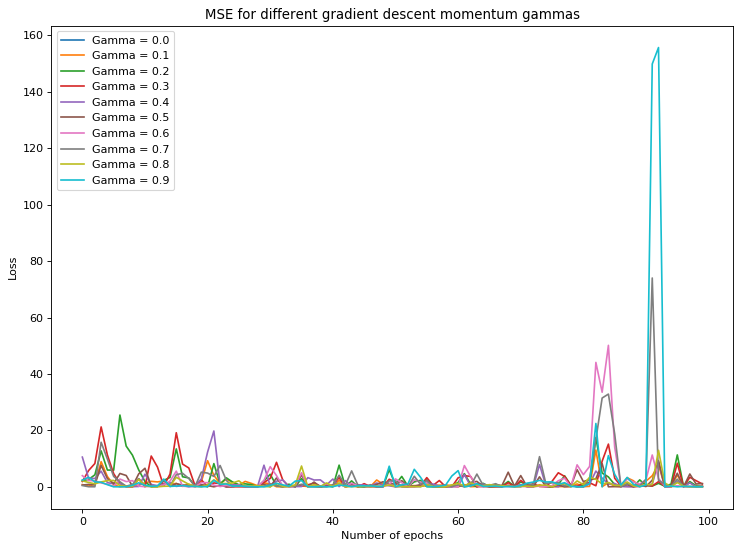

In [14]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

for gamma in gammas:
    plt.plot(history_gamma[str(gamma)][:100], label = f"Gamma = {gamma}")

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('MSE for different gradient descent momentum gammas')
plt.legend();

## 5 -  Nesterov accelerated gradient (NAG)
***
NAG is a way to give our momentum term this kind of prescience. We know that we will use our momentum term γvt−1 to move the parameters $\theta$. Computing $\theta -  \gamma v_{t-1}$ thus gives us an approximation of the next position of the parameters (the gradient is missing for the full update), a rough idea where our parameters are going to be :

$$ v_t = \gamma v_{t-1} + \eta . \nabla{\omega} \mathcal{J}(\omega - \gamma v_{t-1}) $$
$$ \omega = \omega - v_t $$

In [15]:
w = np.random.randn(1,d) # initialization weights 
eta = 1e-4 # step-size 
num_epochs = 20 # number of iteration
gamma = 0.9
#log_iterval = nb_iter // 10
history_nesterov = []
h_nesterov_mean = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()

        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                loss_point = (np.dot(w,x) - y)**2 
                loss += loss_point[0]
                
                if (i == 0) :
                    vlast = 0
                    grad = 2*x*(np.dot(w,x) - y)
                    v = eta*grad
                else :
                    grad = 2*x*(np.dot(w-v,x) - y)
                    v = gamma*vlast + eta*grad
                    vlast = v
                    
                w -= v
          
    loss /= n
    history_nesterov.append(loss)
    i += 1   
    print(np.linalg.norm(w - w_star))
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))

t_nesterov = time.time() - ts   
print("* End training..")

* Start training..
4.261810469999854
Iter : [1/20] ; Loss = 16.81584
2.5198050952478876
Iter : [2/20] ; Loss = 6.63441
1.8546419457732006
Iter : [3/20] ; Loss = 1.81234
1.4607718431549694
Iter : [4/20] ; Loss = 0.96211
1.1769489889806264
Iter : [5/20] ; Loss = 0.67088
0.9593376362676969
Iter : [6/20] ; Loss = 0.52439
0.788522238657142
Iter : [7/20] ; Loss = 0.43884
0.652838952944455
Iter : [8/20] ; Loss = 0.38576
0.5442472199833045
Iter : [9/20] ; Loss = 0.35181
0.45685571635438765
Iter : [10/20] ; Loss = 0.32967
0.3862117696700361
Iter : [11/20] ; Loss = 0.31501
0.32888651035048294
Iter : [12/20] ; Loss = 0.30519
0.2822052672608796
Iter : [13/20] ; Loss = 0.29852
0.24406160749579542
Iter : [14/20] ; Loss = 0.29395
0.21278449618263393
Iter : [15/20] ; Loss = 0.29078
0.18704120357771897
Iter : [16/20] ; Loss = 0.28855
0.1657650683327668
Iter : [17/20] ; Loss = 0.28698
0.14810084447266278
Iter : [18/20] ; Loss = 0.28585
0.1333626086336793
Iter : [19/20] ; Loss = 0.28503
0.121000726491636

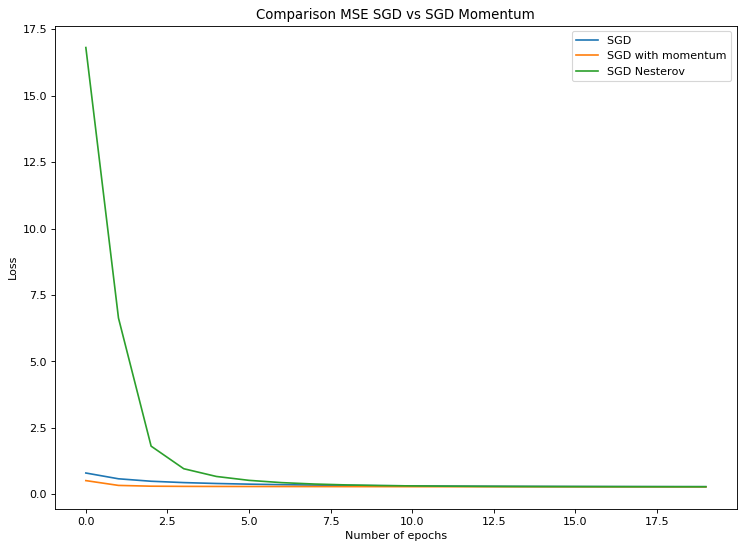

In [16]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_SGD, label = 'SGD ')
plt.plot(history_momentum, label = 'SGD with momentum')
plt.plot(history_nesterov, label = 'SGD Nesterov')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Comparison MSE SGD vs SGD Momentum')
plt.legend();

## 6 - Adagrad
***
Adagrad adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data. The gradient update rule is given by the following expression :

$$ \omega_{t+1} = \omega_{t} - \dfrac{\eta}{\sqrt(G_T + \epsilon)} \odot g_t $$

In [17]:
w = np.zeros((1,d)) # initialization weights 
sum_grad = np.zeros((1,d)) # initialization
eta = 1e-2 # step-size 
num_epochs = 20 # number of iteration
gamma = 0.9 # value from paper
epsilon = 1e-8 
#log_iterval = nb_iter // 10

history_adagrad = []
h_adagrad_mean = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]
            
                sum_grad += grad**2
                adjusted_eta = eta / np.sqrt(epsilon + sum_grad)
                w -= np.multiply(adjusted_eta, grad) # element-wise 
                 
    loss /= n
    history_adagrad.append(loss)  
    i += 1   
    print(np.linalg.norm(w - w_star))
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
        
t_adagrad = time.time() - ts       
print("* End training..")

* Start training..
0.6095157273572225
Iter : [1/20] ; Loss = 0.50892
0.5580933171048431
Iter : [2/20] ; Loss = 0.39181
0.5255340442203643
Iter : [3/20] ; Loss = 0.35512
0.5021272460300917
Iter : [4/20] ; Loss = 0.33383
0.4840899282324625
Iter : [5/20] ; Loss = 0.32002
0.4695435849949015
Iter : [6/20] ; Loss = 0.31045
0.45742365751229397
Iter : [7/20] ; Loss = 0.30350
0.44707272067075793
Iter : [8/20] ; Loss = 0.29827
0.4380591965670219
Iter : [9/20] ; Loss = 0.29422
0.4300864058727509
Iter : [10/20] ; Loss = 0.29102
0.4229428654288939
Iter : [11/20] ; Loss = 0.28843
0.41647330538453387
Iter : [12/20] ; Loss = 0.28630
0.4105608834838155
Iter : [13/20] ; Loss = 0.28452
0.40511581041392125
Iter : [14/20] ; Loss = 0.28302
0.4000678221464638
Iter : [15/20] ; Loss = 0.28173
0.39536105222366036
Iter : [16/20] ; Loss = 0.28061
0.3909504512074497
Iter : [17/20] ; Loss = 0.27964
0.38679923198872945
Iter : [18/20] ; Loss = 0.27878
0.3828770121233459
Iter : [19/20] ; Loss = 0.27802
0.3791584400381

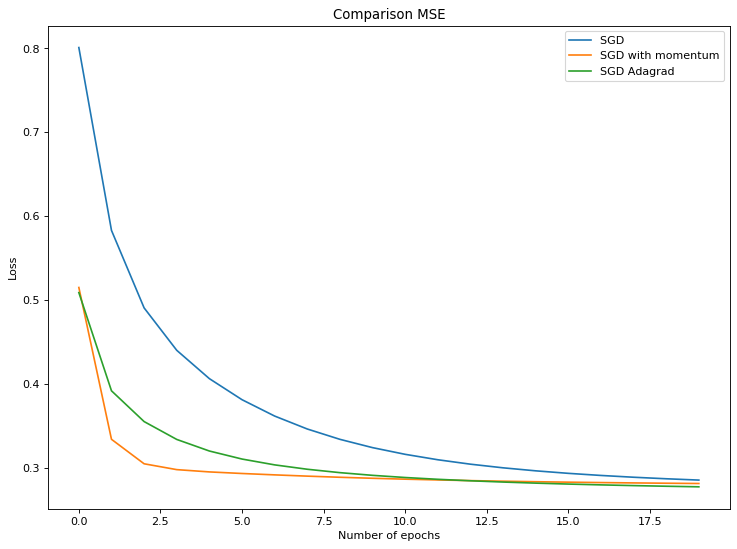

In [18]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_SGD, label = 'SGD ')
plt.plot(history_momentum, label = 'SGD with momentum')
#plt.plot(history_nesterov, label = 'SGD Nesterov')
plt.plot(history_adagrad, label = 'SGD Adagrad ')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Comparison MSE')
plt.legend();

Adagrad is working fine, however we noticed that we needed a step much larger than for momentum and Nesterov. Changing the step size $\eta$ makes the comparison between methods harder. However, if we select such value for Adagrad, the curve is smoother and we reach approximately the same convergence. 

## 7 -  Adadelta
***
It is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients : the sum of gradients is recursively defined as a decaying average of all past squared gradients. 

$$ \omega_{t+1} = \omega_{t} - \dfrac{RMS[\Delta \omega]_{t+1}}{RMS[g]_{t}} g_t $$
$$ \omega_{t+1} = \omega_{t} + \Delta \omega_t $$

In [19]:
w = np.zeros((1,d)) # initialization weights 
delta = np.zeros((1,d))

eta = 3e-2
num_epochs = 20 # number of iteration
Eg_prev = 0.
Ed_prev = 0.
RMSg = 0.
RMSd = 0.
gamma = 0.9 # classic value
epsilon = 1e-8
#log_iterval = nb_iter // 10

history_adadelta = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()

        if (n_in_batch > 0):    
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]

                Eg = gamma * Eg_prev + (1-gamma) * grad**2
                RMSg = np.sqrt(Eg  + epsilon)

                w -= (RMSd / RMSg) * grad

                ###
                delta -= (eta / RMSg) * grad
                Ed = gamma * Eg_prev + (1-gamma) * delta**2
                RMSd = np.sqrt(Ed  + epsilon)

                Eg_prev = Eg
                Ed_prev = Ed
    
    loss /= n
    history_adadelta.append(loss)
    i += 1   
    print(np.linalg.norm(w-w_star))
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
    
t_adelta = time.time() - ts       
print("* End training..")

* Start training..
6.693080963128318e+143
Iter : [1/20] ; Loss = 1130381656663997920351217386675658671002180959193913690527232792772209141468824581396354299634297684746822797919381576297628011395203749829078925848749250993671432254601975594368742750131371547785249237024260832168729842474609211397913523026236123542086780111976610501863352024359239680.00000


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in square
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


nan
Iter : [2/20] ; Loss = nan
nan
Iter : [3/20] ; Loss = nan
nan
Iter : [4/20] ; Loss = nan
nan
Iter : [5/20] ; Loss = nan
nan
Iter : [6/20] ; Loss = nan
nan
Iter : [7/20] ; Loss = nan
nan
Iter : [8/20] ; Loss = nan
nan
Iter : [9/20] ; Loss = nan
nan
Iter : [10/20] ; Loss = nan
nan
Iter : [11/20] ; Loss = nan
nan
Iter : [12/20] ; Loss = nan
nan
Iter : [13/20] ; Loss = nan
nan
Iter : [14/20] ; Loss = nan
nan
Iter : [15/20] ; Loss = nan
nan
Iter : [16/20] ; Loss = nan
nan
Iter : [17/20] ; Loss = nan
nan
Iter : [18/20] ; Loss = nan
nan
Iter : [19/20] ; Loss = nan
nan
Iter : [20/20] ; Loss = nan
* End training..


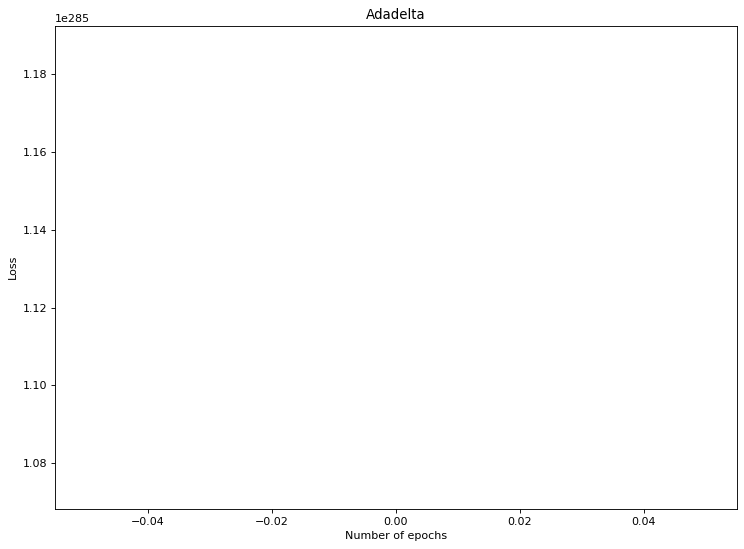

In [20]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_adadelta)

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Adadelta');

## 8 - RMSprop
***
RMSprop as well divides the learning rate by an exponentially decaying average of squared gradients :

$$ E[{g^2}]_t = 0.9 E[{g^2}]_{t-1} + 0.1 g_{t}^2 $$
$$ \omega_{t+1} = \omega_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t $$

In [21]:
w = np.zeros((1,d)) # initialization weights 
delta = np.zeros((1,d)) # initialization
Eg_prev = 0.
Ed_prev = 0.
gamma = 0.9 # classic value
epsilon = 1e-8
eta = 1e-3 # step-size 
num_epochs = 20 # number of iteration
#log_iterval = num_epochs // 10

history_RMS = []

print("* Start training..")
ts = time.time()
i = 0 
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]
                
                ###
                Eg = gamma * Eg_prev + (1-gamma) * grad**2
                RMSg = np.sqrt(Eg  + epsilon)

                w -= (eta / RMSg) * grad

                Eg_prev = Eg
    
    loss /= n
    history_RMS.append(loss)
    i += 1   
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
    
t_RMS = time.time() - ts       
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.55641
Iter : [2/20] ; Loss = 0.36352
Iter : [3/20] ; Loss = 0.30980
Iter : [4/20] ; Loss = 0.29372
Iter : [5/20] ; Loss = 0.28910
Iter : [6/20] ; Loss = 0.28762
Iter : [7/20] ; Loss = 0.28697
Iter : [8/20] ; Loss = 0.28651
Iter : [9/20] ; Loss = 0.28610
Iter : [10/20] ; Loss = 0.28570
Iter : [11/20] ; Loss = 0.28532
Iter : [12/20] ; Loss = 0.28496
Iter : [13/20] ; Loss = 0.28463
Iter : [14/20] ; Loss = 0.28432
Iter : [15/20] ; Loss = 0.28404
Iter : [16/20] ; Loss = 0.28378
Iter : [17/20] ; Loss = 0.28354
Iter : [18/20] ; Loss = 0.28332
Iter : [19/20] ; Loss = 0.28311
Iter : [20/20] ; Loss = 0.28292
* End training..


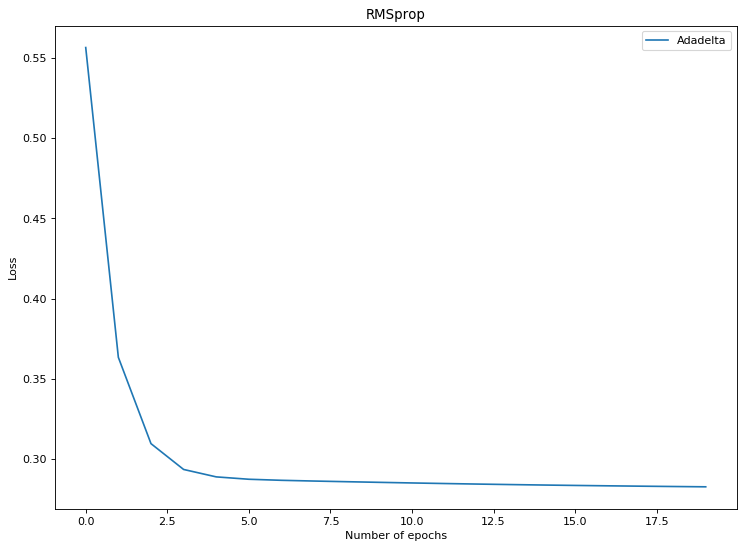

In [22]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_RMS, label = 'Adadelta')

plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.title('RMSprop');

## 9 - Adaptive Moment Estimation (Adam)
***
Another method that computes adaptive learning rates for each parameter :

$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$
$$ v_t = \beta_2 v_{t-1} +(1 - \beta_2) g_t^2 $$
$$ \omega_{t+1} = \omega_t - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t $$

In [23]:
w = np.zeros((1,d)) # initialization weights 
delta = np.zeros((1,d))
mom_prev = 0.
v_prev = 0.

eta = 1e-4 # step-size 
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
num_epochs = 20 # number of iteration
#log_iterval = nb_iter // 10

history_adam = []

print("* Start training..")
ts = time.time()
i = 0 
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()

        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]
                
                mom = beta1 * mom_prev + (1-beta1) * grad 
                v = beta2 * v_prev + (1-beta2) * grad**2

                avg_mom = mom / (1 - beta1)
                avg_v = v / (1 - beta1)

                w -= (eta / np.sqrt(avg_v)) * avg_mom

                v_prev = v
                mom_prev = mom 
                
    loss /= n
    history_adam.append(loss)
    i += 1   
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
                    
t_adam = time.time() - ts       
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.55527
Iter : [2/20] ; Loss = 0.40953
Iter : [3/20] ; Loss = 0.36102
Iter : [4/20] ; Loss = 0.33245
Iter : [5/20] ; Loss = 0.31454
Iter : [6/20] ; Loss = 0.30292
Iter : [7/20] ; Loss = 0.29517
Iter : [8/20] ; Loss = 0.28988
Iter : [9/20] ; Loss = 0.28615
Iter : [10/20] ; Loss = 0.28343
Iter : [11/20] ; Loss = 0.28139
Iter : [12/20] ; Loss = 0.27980
Iter : [13/20] ; Loss = 0.27852
Iter : [14/20] ; Loss = 0.27745
Iter : [15/20] ; Loss = 0.27655
Iter : [16/20] ; Loss = 0.27577
Iter : [17/20] ; Loss = 0.27508
Iter : [18/20] ; Loss = 0.27446
Iter : [19/20] ; Loss = 0.27391
Iter : [20/20] ; Loss = 0.27340
* End training..


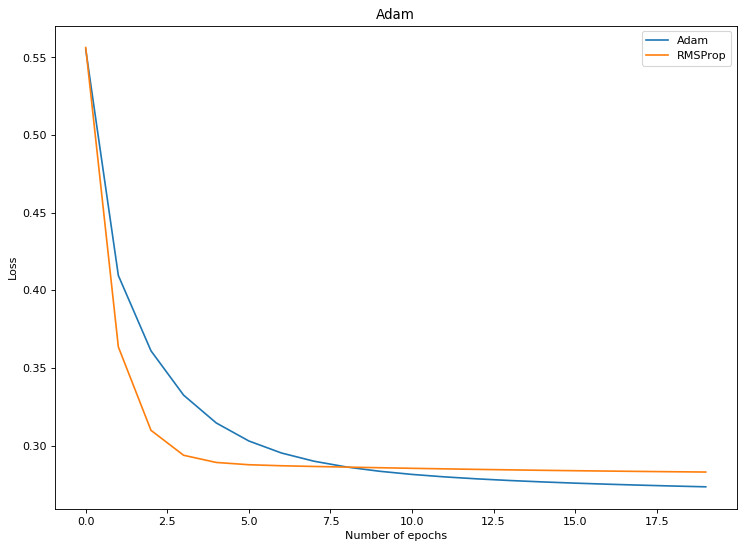

In [24]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_adam, label = 'Adam')
#plt.plot(history_adadelta, label = 'Adadelta')
plt.plot(history_RMS, label = 'RMSProp')

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Adam');

## 10 - AdaMax
***
It is a generalization of the $v_t$ update with the $l_{\infty}$ norm :


$$ u_t = \beta_2^{\infty} v_{t-1} +(1 - \beta_2^{\infty}) \mid g_t\mid^{\infty} = max(\beta_2 . v_{t-1}, \mid g_t \mid) $$
$$ \omega_{t+1} = \omega_t - \dfrac{\eta}{u_t} \hat{m}_t $$

In [25]:
w = np.zeros((1,d)) # initialization weights 
delta = np.zeros((1,d))
mom_prev = 0.
u_prev = 0.

eta = 1e-4 # step-size 
num_epochs = 20 # number of iteration
beta1 = 0.9
beta2 = 0.999
#log_iterval = nb_iter // 10

history_adamax = []
        
print("* Start training..")
ts = time.time()
i = 0 
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]

                mom = beta1 * mom_prev + (1-beta1) * grad 
                v = beta2 * v_prev + (1-beta2) * grad**2

                avg_mom = mom / (1 - beta1)
                avg_v = v / (1 - beta1)
                u = np.maximum(beta2 * v_prev, np.abs(grad))

                avg_mom = mom / (1 - beta1)
                avg_v = v / (1 - beta1)
                w -= (eta / u) * avg_mom

                v_prev = v
                mom_prev = mom 
    
    loss /= n
    history_adamax.append(loss)
    i += 1   
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
        
t_adamax = time.time() - ts  
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.60410
Iter : [2/20] ; Loss = 0.42666
Iter : [3/20] ; Loss = 0.35934
Iter : [4/20] ; Loss = 0.32329
Iter : [5/20] ; Loss = 0.30383
Iter : [6/20] ; Loss = 0.29332
Iter : [7/20] ; Loss = 0.28754
Iter : [8/20] ; Loss = 0.28423
Iter : [9/20] ; Loss = 0.28218
Iter : [10/20] ; Loss = 0.28081
Iter : [11/20] ; Loss = 0.27983
Iter : [12/20] ; Loss = 0.27909
Iter : [13/20] ; Loss = 0.27850
Iter : [14/20] ; Loss = 0.27801
Iter : [15/20] ; Loss = 0.27760
Iter : [16/20] ; Loss = 0.27725
Iter : [17/20] ; Loss = 0.27694
Iter : [18/20] ; Loss = 0.27668
Iter : [19/20] ; Loss = 0.27644
Iter : [20/20] ; Loss = 0.27624
* End training..


Text(0.5, 1.0, 'Adamax')

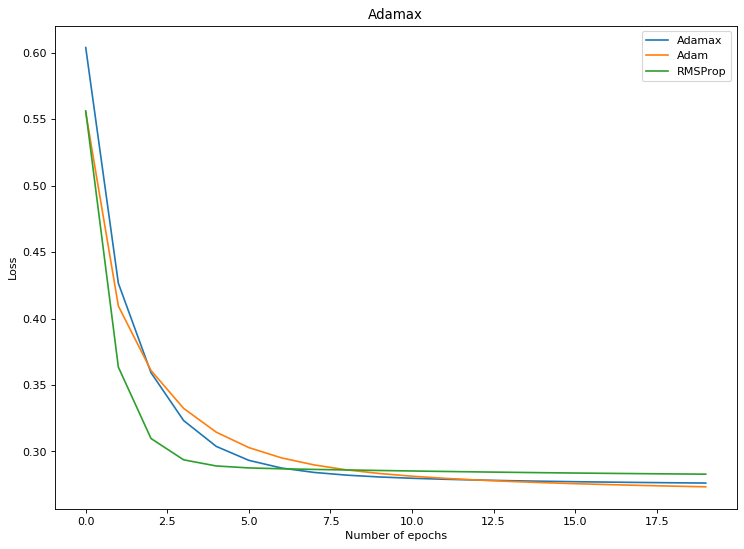

In [26]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_adamax, label = 'Adamax')
plt.plot(history_adam, label = 'Adam')
#plt.plot(history_adadelta, label = 'Adadelta')
plt.plot(history_RMS, label = 'RMSProp')

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Adamax')

## 11 - Nadam 
***
This is a combination of Adam and Nestorov :

$$ \Delta \omega_t = - \dfrac{RMS[\Delta \omega]_{t-1}}{RMS[g]_t} g_t $$
$$ \omega_{t+1} = \omega_t + \Delta \omega_t $$

In [27]:
w = np.zeros((1,d)) # initialization weights 
delta = np.zeros((1,d))
mom_prev = 0.
u_prev = 0.

eta = 1e-4 # step-size 
num_epochs = 20 # number of iteration
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999

history_nadam = []

print("* Start training..")
ts = time.time()
i = 0
while i < num_epochs:
    loss = 0.
    
    for j in range(nb_repart):
        batch = rdd.filter(lambda x: x[1] == j)
        batch = batch.flatMap(lambda x: x[0])
        n_in_batch = batch.count()
        
        if (n_in_batch > 0):
            for k,r in enumerate(batch.take(n_in_batch)) : 
                x = r[:d]
                y = r[d:]
                grad = 2*x*(np.dot(w,x) - y)
                loss_point = (np.dot(w,x) - y)**2
                loss += loss_point[0]
                
                mom = beta1 * mom_prev + (1-beta1) * grad 
                v = beta2 * v_prev + (1-beta2) * grad**2

                avg_mom = mom / (1 - beta1)
                avg_v = v / (1 - beta1)
                u = np.maximum(beta2 * v_prev, np.abs(grad))

                avg_mom = mom / (1 - beta1)
                avg_v = v / (1 - beta1)
                w -= (eta / (np.sqrt(avg_v)+ epsilon)) * (beta1 * avg_mom + ((1-beta1)* grad)/(1-beta1))

                v_prev = v
                mom_prev = mom 
    
    loss /= n
    history_nadam.append(loss)
    i += 1   
    print("Iter : [{}/{}] ; Loss = {:.5f}".format(i, num_epochs, loss))
    
t_nadam = time.time() - ts           
print("* End training..")

* Start training..
Iter : [1/20] ; Loss = 0.69512
Iter : [2/20] ; Loss = 0.49240
Iter : [3/20] ; Loss = 0.42396
Iter : [4/20] ; Loss = 0.37902
Iter : [5/20] ; Loss = 0.34761
Iter : [6/20] ; Loss = 0.32574
Iter : [7/20] ; Loss = 0.31061
Iter : [8/20] ; Loss = 0.30017
Iter : [9/20] ; Loss = 0.29293
Iter : [10/20] ; Loss = 0.28787
Iter : [11/20] ; Loss = 0.28426
Iter : [12/20] ; Loss = 0.28163
Iter : [13/20] ; Loss = 0.27966
Iter : [14/20] ; Loss = 0.27814
Iter : [15/20] ; Loss = 0.27693
Iter : [16/20] ; Loss = 0.27594
Iter : [17/20] ; Loss = 0.27510
Iter : [18/20] ; Loss = 0.27439
Iter : [19/20] ; Loss = 0.27376
Iter : [20/20] ; Loss = 0.27321
* End training..


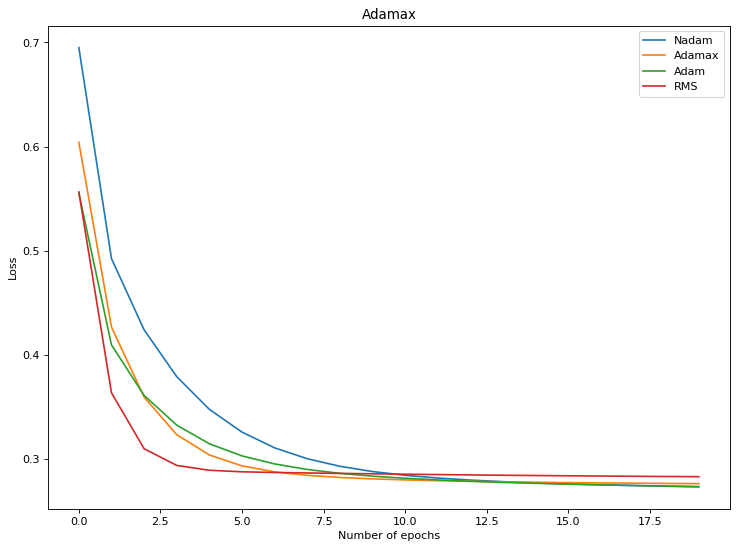

In [28]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_nadam, label = 'Nadam')
plt.plot(history_adamax, label = 'Adamax')
plt.plot(history_adam, label = 'Adam')
#plt.plot(history_adadelta, label = 'Adadelta')
plt.plot(history_RMS, label = 'RMS')

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Adamax');

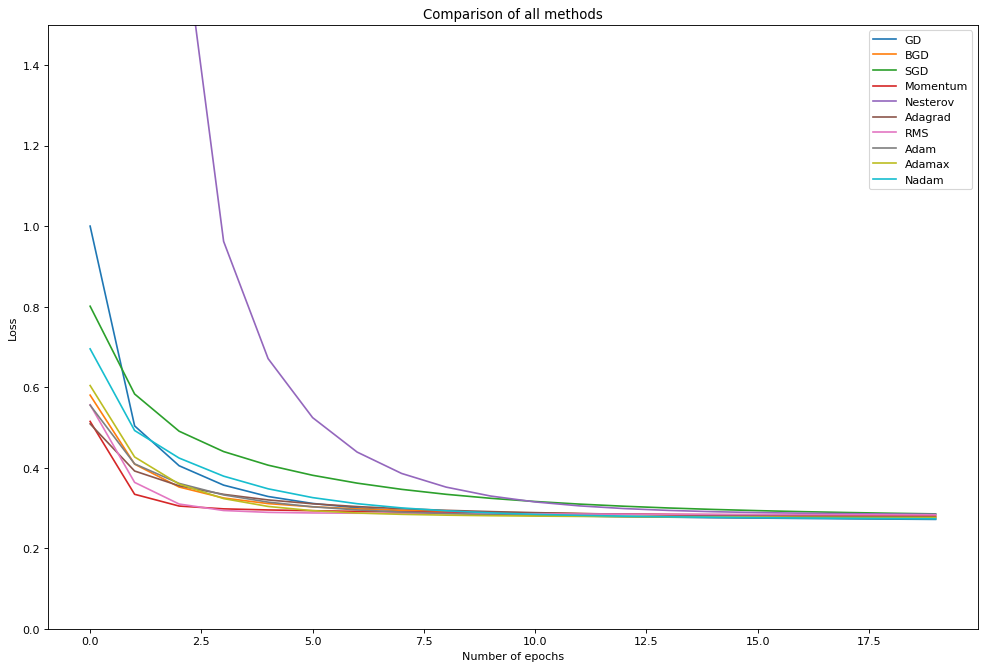

In [33]:
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_GD, label = 'GD')
plt.plot(history_BGD, label = 'BGD')
plt.plot(history_SGD, label = 'SGD')
plt.plot(history_momentum, label = 'Momentum')
plt.plot(history_nesterov, label = 'Nesterov')
plt.plot(history_adagrad, label = 'Adagrad')
plt.plot(history_RMS, label = 'RMS')
plt.plot(history_adam, label = 'Adam')
plt.plot(history_adamax, label = 'Adamax')
plt.plot(history_nadam, label = 'Nadam')


plt.xlabel("Number of epochs")
#plt.xlim([0, 10])
plt.ylabel("Loss")
plt.ylim([0, 1.5])
plt.title('Comparison of all methods')
plt.legend();